In [2]:
import os
import tridy
from tridy import GeoConcept, SubGeoConcept, MetaData, Table, View, DBStorage, DataSource, Feature, FeatureWithID,  AdmUnitFeature, FeatureWithRasterMap, OLUFeature, Grid, Imagee, ds_from_metadata, xml_lpis_cz_reader, lpis_cz__posledni_aktualizace, get_listvalues_from_generator, apply_function, select_nodes_from_graph, unzip_file, find_neighbors_till, connection_parameters_to_pg, transform_name_to_postgresql_format, world_to_pixel 
from importlib import reload
import requests
import datetime
import re
from io import BytesIO

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

from osgeo import ogr, osr, gdal
import networkx as nx
import numpy as np
import json
import binascii
import copy
import time

from lxml import etree

import random
from ipyleaflet import Map, GeoJSON

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from pygeoprocessing import routing

import tempfile
from tempfile import TemporaryDirectory

from importlib import reload

In [3]:
del(tridy)
del(FeatureWithID)
import tridy
from tridy import FeatureWithID

In [4]:
json_feature_structure=[{"name":"id","type":"serial primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"}]
json_feature_with_raster_structure=[{"name":"id","type":"serial primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"},{"name":"raster_maps","type":"raster"}]

In [5]:
def get_twi(im_object):
    with TemporaryDirectory() as tempdir:
        im_object.export_as_tif('%s/dem.tif' %tempdir)
        routing.fill_pits(('%s/dem.tif' %tempdir,1),'%s/cdem.tif' %tempdir)
        routing.flow_dir_mfd(('%s/cdem.tif' %tempdir,1),'%s/dir.tif' %tempdir)
        routing.flow_accumulation_mfd(('%s/dir.tif' %tempdir,1),'%s/twi.tif' %tempdir)
        ds = gdal.Open('%s/twi.tif' %tempdir)
        metadata_dict=im_object.get_metadata()
        twi=Imagee(np.array(ds.GetRasterBand(1).ReadAsArray()),metadata_dict)
        return twi

In [6]:
fields_metadata=MetaData('Pessl fields database',
                             {"local":"/home/jovyan/public/shared/Scenario5/Field_borders/Field035.geojson", "format":"GeoJSON"},
                             'data')

fields_ds=ds_from_metadata(fields_metadata)

fields=GeoConcept('Pessl fields','Fields of farmers that are using Pessl instruments',
                      'Feature',json_feature_structure, data_source=fields_ds, subgeoconcepts=[] )

In [7]:
fields.get_data_source().set_data_file('/home/jovyan/public/shared/Scenario5/Field_borders/Field035.geojson')

In [8]:
features=fields.get_data_source().read_features('feature',number=1)
feature=next(features)[0]

In [9]:
import os
os.path.isfile('/home/jovyan/public/dem/eu_dem_czat3035.tif')

True

In [10]:
dem30_fn='/home/jovyan/public/dem/eu_dem_czat3035.tif'
dem30=gdal.Open(dem30_fn)

In [11]:
wgs84_sr,etrs3035_sr=[osr.SpatialReference() for i in range(2)]

wgs84_sr.ImportFromProj4('+proj=longlat +datum=WGS84 +no_defs')
etrs3035_sr.ImportFromProj4('+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs')

wgs84_to_etrs3035=osr.CoordinateTransformation(wgs84_sr,etrs3035_sr)
etrs3035_to_wgs84=osr.CoordinateTransformation(etrs3035_sr,wgs84_sr)

In [12]:
metadata_dict={}
metadata_dict['affine_transformation']=dem30.GetGeoTransform()
metadata_dict['nodata']=dem30.GetRasterBand(1).GetNoDataValue()
metadata_dict['proj_wkt']=etrs3035_sr.ExportToWkt()

In [13]:
grid=Grid((metadata_dict['affine_transformation'][0],metadata_dict['affine_transformation'][3]),(metadata_dict['affine_transformation'][1],metadata_dict['affine_transformation'][5]))

In [14]:
feature.transform_geometry(wgs84_to_etrs3035)

In [15]:
envelope=np.add(ogr.CreateGeometryFromWkt(feature.get_geometry()).GetEnvelope(),(-300,300,-300,300))

In [16]:
origin=tuple(grid.find_index((envelope[0],envelope[3])))

In [17]:
size=tuple(np.array(grid.find_index((envelope[1],envelope[2])))-np.array(grid.find_index((envelope[0],envelope[3]))))+np.array([1,1])

In [18]:
a=np.array(dem30.GetRasterBand(1).ReadAsArray(xoff=int(origin[0]),yoff=int(origin[1]),win_xsize=int(size[0]),win_ysize=int(size[1])))

In [19]:
grid_clip=Grid(np.array(grid.get_gridorigin())+np.array(tuple(grid.find_index((envelope[0],envelope[3]))))*np.array(grid.get_gridstepsize()),(metadata_dict['affine_transformation'][1],metadata_dict['affine_transformation'][5]))

In [20]:
clip_metadata_dict={}
clip_metadata_dict['affine_transformation']=grid_clip.get_affinetransformation()
clip_metadata_dict['nodata']=float(np.min(a)) if np.min(a)<0 else np.nan
clip_metadata_dict['proj_wkt']=etrs3035_sr.ExportToWkt()

In [21]:
big_im=Imagee(a,clip_metadata_dict)

In [22]:
big_twi=get_twi(big_im)
big_orientation=Imagee(*big_im.calculate_azimuth())
big_slope=Imagee(*big_im.calculate_slope())

In [23]:
feature_geomorpho=FeatureWithRasterMap(data={},geom=('POLYGON ((%d %d, %d %d, %d %d, %d %d, %d %d))' % (envelope[0],envelope[2],envelope[0],envelope[3],envelope[1],envelope[3],envelope[1],envelope[2],envelope[0],envelope[2])),id=1,raster_map={'dem':big_im,'slope':big_slope,'orientation':big_orientation,'twi':big_twi})

In [ ]:
raster_files={'aglim1':'/home/jovyan/public/soil_maps/European_soil_database_and_soil_properties/European_Soil_Database_v2_Raster_Library_1kmx1km/Limitation_to_Agricultural_use/AGLIM1/aglim1_directory/aglim1/w001001x.adf', 'aglim2':'/home/jovyan/public/soil_maps/European_soil_database_and_soil_properties/European_Soil_Database_v2_Raster_Library_1kmx1km/Limitation_to_Agricultural_use/AGLIM2/aglim2_directory/aglim2/w001001x.adf'}

In [ ]:
aglim1_ds=gdal.Open(raster_files['aglim1'])
aglim2_ds=gdal.Open(raster_files['aglim2'])

metadata_dict={}

metadata_dict['affine_transformation']=aglim1_ds.GetGeoTransform()
metadata_dict['nodata']=aglim1_ds.GetRasterBand(1).GetNoDataValue()
metadata_dict['proj_wkt']=etrs3035_sr.ExportToWkt()
aglim1_im=Imagee(np.array(aglim1_ds.GetRasterBand(1).ReadAsArray()),metadata_dict)
del(aglim1_ds)

metadata_dict['affine_transformation']=aglim2_ds.GetGeoTransform()
metadata_dict['nodata']=aglim2_ds.GetRasterBand(1).GetNoDataValue()
aglim2_im=Imagee(np.array(aglim2_ds.GetRasterBand(1).ReadAsArray()),metadata_dict)
del(aglim2_ds)

In [56]:
agricultural_limitations={0: 'No information', 1: 'No limitation to agricultural use', 2: 'Gravelly (over 35% gravel diameter < 7.5 cm)', 3: 'Stony (presence of stones diameter > 7.5 cm,impracticable mechanisation)', 4: 'Lithic (coherent and hard rock within 50 cm)', 5: 'Concretionary (over 35% concretions diameter < 7.5 cm near the surface)', 6: 'Petrocalcic (cemented or indurated calcic horizon within 100 cm)', 7: 'Saline (electric conductivity > 4 mS.cm-1 within 100 cm)', 8: 'Sodic (Na/T > 6% within 100 cm)', 9: 'Glaciers and snow-caps', 10: 'Soils disturbed by man (i.e. landfills, paved surfaces, mine spoils)', 11: 'Fragipans', 12: 'Excessively drained', 13: 'Almost always flooded', 14: 'Eroded phase, erosion', 15: 'Phreatic phase (shallow water table)', 18: 'Permafrost'}

In [97]:
ul,lr=(aglim2_im.get_metadata()['affine_transformation'])[slice(0,6,3)],np.add((aglim2_im.get_metadata()['affine_transformation'])[slice(0,6,3)],np.multiply(np.flip(aglim2_im.get_data().shape),(aglim2_im.get_metadata()['affine_transformation'])[slice(1,6,4)]))

In [100]:
feature_eu_soils=FeatureWithRasterMap(data={},geom=('POLYGON ((%d %d, %d %d, %d %d, %d %d, %d %d))' % (ul[0],lr[1],ul[0],ul[1],lr[0],ul[1],lr[0],lr[1],ul[0],lr[1])),id=1,raster_map={'aglim1':aglim1_im,'aglim2':aglim2_im})

In [103]:
feature_eu_soils.get_raster_map()['aglim2'].get_data().shape

(5500, 7500)

In [104]:
def compilable_transformation_dictionary(feature_var, feature_geomorpho_var, feature_soils):
    t_dict=\
    {'feature':{'object':feature_var}, \
    'feature_id':{'function':(lambda y: y.get_id() if type(y)!=tridy.Feature else 1),'parameters':['feature']},\
    'feature_data':{'function':(lambda y: y.get_data()),'parameters':['feature']},\
    'feature_geometry':{'function':(lambda y: y.get_geometry()),'parameters':['feature']},\
    'feature_geomorpho':{'object': feature_geomorpho_var}, \
    'feature_dem':{'function':(lambda y,  z:  Imagee(*y.get_raster_map()['dem'].clip_by_shape(z))    ),'parameters':['feature_geomorpho','feature_geometry']},\
    'feature_slope':{'function':(lambda y,  z:  Imagee(*y.get_raster_map()['slope'].clip_by_shape(z))    ),'parameters':['feature_geomorpho','feature_geometry']},\
    'feature_orientation':{'function':(lambda y,  z:  Imagee(*y.get_raster_map()['orientation'].clip_by_shape(z))    ),'parameters':['feature_geomorpho','feature_geometry']},\
    'feature_twi':{'function':(lambda y,  z:  Imagee(*y.get_raster_map()['twi'].clip_by_shape(z))    ),'parameters':['feature_geomorpho','feature_geometry']},\
    'feature_soils':{'object': feature_soils}, \
    'feature_aglim1':{'function':(lambda y,  z:  Imagee(*y.get_raster_map()['aglim1'].clip_by_shape(z))    ),'parameters':['feature_soils','feature_geometry']},\
    'feature_aglim2':{'function':(lambda y,  z:  Imagee(*y.get_raster_map()['aglim2'].clip_by_shape(z))    ),'parameters':['feature_soils','feature_geometry']},\
    'result_feature':{'function':(lambda r, s, t, u, v,  w,  x,  y,  z:  FeatureWithRasterMap(data=r, geom=s,id=t,raster_map={'dem':u,'slope':v,'orientation':w,'twi':x,'aglim1':y,'aglim2':z})   ),'parameters':['feature_data','feature_geometry','feature_id','feature_dem', 'feature_slope', 'feature_orientation', 'feature_twi', 'feature_aglim1', 'feature_aglim2']},\
    }
    return t_dict

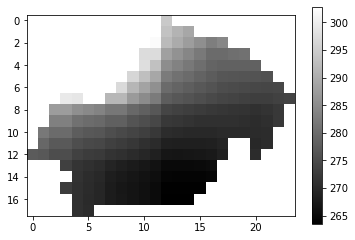

In [106]:
plt.imshow(apply_function(compilable_transformation_dictionary(feature,feature_geomorpho,feature_eu_soils),'result_feature').get_raster_map()['dem'].get_data(), origin="upper", cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

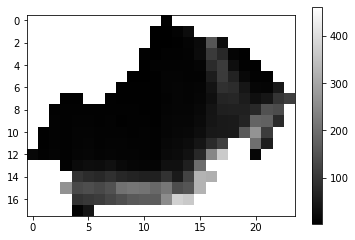

In [107]:
plt.imshow(apply_function(compilable_transformation_dictionary(feature,feature_geomorpho,feature_eu_soils),'result_feature').get_raster_map()['twi'].get_data(), origin="upper", cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

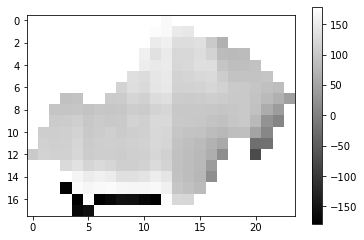

In [108]:
plt.imshow(apply_function(compilable_transformation_dictionary(feature,feature_geomorpho,feature_eu_soils),'result_feature').get_raster_map()['orientation'].get_data(), origin="upper", cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

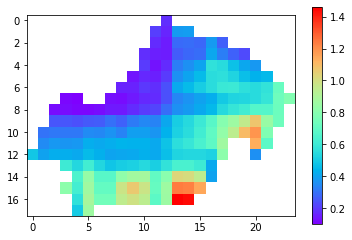

In [109]:
plt.imshow(apply_function(compilable_transformation_dictionary(feature,feature_geomorpho,feature_eu_soils),'result_feature').get_raster_map()['slope'].get_data(), origin="upper", cmap='rainbow', interpolation='nearest')
plt.colorbar()
plt.show()

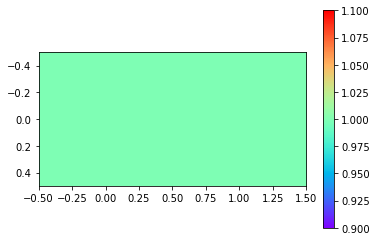

In [110]:
plt.imshow(apply_function(compilable_transformation_dictionary(feature,feature_geomorpho,feature_eu_soils),'result_feature').get_raster_map()['aglim1'].get_data(), origin="upper", cmap='rainbow', interpolation='nearest')
plt.colorbar()
plt.show()

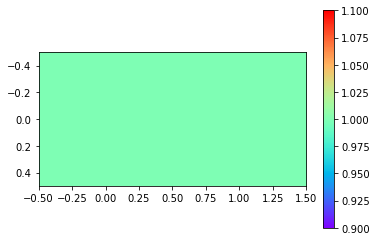

In [111]:
plt.imshow(apply_function(compilable_transformation_dictionary(feature,feature_geomorpho,feature_eu_soils),'result_feature').get_raster_map()['aglim2'].get_data(), origin="upper", cmap='rainbow', interpolation='nearest')
plt.colorbar()
plt.show()

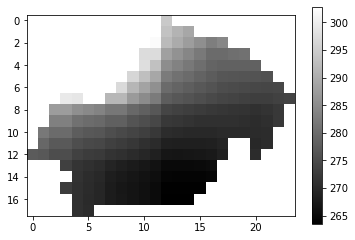

In [112]:
plt.imshow(apply_function(compilable_transformation_dictionary(feature,feature_geomorpho,feature_eu_soils),'feature_dem').get_data(), origin="upper", cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [29]:
#import os
#os.getcwd()
#os.listdir('/home/jovyan/public/soil_maps/European_soil_database_and_soil_properties/European_Soil_Database_v2_Raster_Library_1kmx1km/Limitation_to_Agricultural_use/AGLIM1/aglim1_directory/aglim1')
#os.listdir('/home/jovyan/public/soil_maps/European_soil_database_and_soil_properties/European_Soil_Database_v2_Raster_Library_1kmx1km/Limitation_to_Agricultural_use/AGLIM2/aglim2_directory/aglim2')